# lab9 - Named entity recognition

The exercise shows how we may extract elements such as names of companies, countries and similar objects from text.

In [69]:
import json
import glob, os
import time
from pathlib import Path
from urllib.request import urlopen, Request
from tqdm import tqdm
import numpy as np
import xml.etree.ElementTree as ET
from typing import List, Tuple, Iterator
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain

In [2]:
url="http://ws.clarin-pl.eu/nlprest2/base" 
data_path = Path("../data/")   
out_path= Path("out")
if not out_path.exists():
    out_path.mkdir()

## Tasks

1. Read the classification of [Named Entities](http://clarin-pl.eu/pliki/warsztaty/Wyklad3-inforex-liner2.pdf).

2. Read the [API of NER](http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki) in [Clarin](http://ws.clarin-pl.eu/ner.shtml).

In [3]:
def upload(file: Path):    
    with file.open("rb") as f:
        doc = f.read()
    return urlopen(Request(url+'/upload/',doc,{'Content-Type': 'binary/octet-stream'})).read().decode("utf-8");

In [13]:
def tool(lpmn: str): 
    data = dict(
        lpmn=lpmn,
        user="user@user.gmail.com"
    )
    doc = json.dumps(data).encode("utf-8")
    taskid = urlopen(Request(url+'/startTask/',doc,{'Content-Type': 'application/json'})).read().decode("utf-8");
    time.sleep(0.1);
    resp = urlopen(Request(url+'/getStatus/'+taskid));
    data = json.load(resp)
    while data["status"] == "QUEUE" or data["status"] == "PROCESSING" :
        time.sleep(0.1);
        resp = urlopen(Request(url+'/getStatus/'+taskid));
        data = json.load(resp)
    if data["status"]=="ERROR":
        print(data)
        return None   
    return data["value"]

In [23]:
def liner2(in_file: Path, out_file: Path):
    data=upload(in_file)
    data=tool('file('+data+')|any2txt|wcrft2|liner2({\"model\":\"all\"})')
    if data is None:
        print("couldn't process", in_file)
        return None
    data=data[0]["fileID"];
    content = urlopen(Request(url+'/download'+data)).read().decode("utf-8");    
    with out_file.open("w") as outfile:
        outfile.write(content)  

3. Read the [documentation of CLL format](http://nlp.pwr.wroc.pl/redmine/projects/corpus2/wiki/CCL_format).

4. Randomly select 100 bills.

In [24]:
data_files = data_path.glob("*.txt")
bills = np.random.choice(list(data_files), 100)

5. Recognize the named entities in the documents using the `n82` model.

In [34]:
def pass_through_liner(bill: Path):
    out_bill = (out_path / bill.name.replace("txt", "xml"))
    result = True
    if not out_bill.exists():
        try:
            liner2(bill, out_bill)
            result = True
        except:
            retult = False
#     print(bill, result)
    return result

In [36]:
import multiprocessing
pool = multiprocessing.Pool()
processed = pool.map(pass_through_liner, bills)
all(processed)

True

Process ForkPoolWorker-39:
Process ForkPoolWorker-35:
Process ForkPoolWorker-40:
Process ForkPoolWorker-36:
Process ForkPoolWorker-37:
Process ForkPoolWorker-38:
Process ForkPoolWorker-33:
Process ForkPoolWorker-34:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mprzewie/.anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mprzewie/.anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mprzewie/.anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mprzewie/.anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mprzewie/.anaconda3/lib/python3.7/multiprocessing/process.py"

6. Plot the frequency of the recognized classes:

In [66]:
def words_with_classes(xml: Path) -> Iterator[Tuple[str, List[str]]]:
    root = ET.parse(xml).getroot()
    for c in root:
        for s in c:
            for t in s:
                if t.tag=="tok":
                    yield (
                        [e.text for e in t if e.tag=="orth"][0],
                        [e.attrib["chan"] for e in t if e.tag=="ann"]    
                    )


generator

In [93]:
all_classes = chain.from_iterable([
    
    chain.from_iterable(
        [(wwc[0], w) for w in wwc[1]]
        for wwc in words_with_classes(xml)
    )
    for xml in out_path.glob("*.xml")
])

df = pd.DataFrame(list(all_classes), columns=["entity", "class"])

   a) fine-grained classification histogram (classes such as `nam_fac_bridge`, `nam_liv_animal`).

In [119]:
fine_grained = lambda x: x["class"].startswith("nam_") and len([c for c in x["class"] if c=="_"])>=2

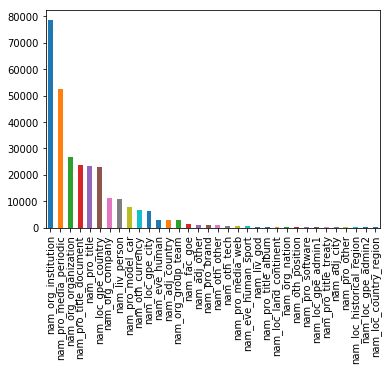

In [120]:
fig, ax = plt.subplots()
df[
    df.apply(fine_grained, axis=1)
]["class"].value_counts().plot(ax=ax, kind="bar")

   
   b) coarse-grained classification histogram (classes such as `nam_adj`, `nam_eve`, `nam_fac`).

In [121]:
coarse_grained = lambda x: x["class"].startswith("nam_") and len([c for c in x["class"] if c=="_"])==1

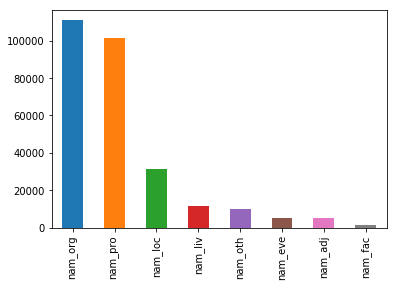

In [122]:
fig, ax = plt.subplots()
df[
    df.apply(coarse_grained, axis=1)
]["class"].value_counts().plot(ax=ax, kind="bar")

7. Display 50 most frequent Named Entities including their count and fine-grained type.

In [138]:
counts = {}

for _, r in df.iterrows():
    row = (r["entity"], r["class"])
    counts[row] = counts.get(row, 0) + 1

In [154]:
sorted(
    [i for i in counts.items() if fine_grained({"class": i[0][1]}) and i[0][0].isalpha()],
    key=lambda i: i[1],
    reverse=True
)[:50]

[(('w', 'nam_org_institution'), 3231),
 (('i', 'nam_org_institution'), 1430),
 (('z', 'nam_pro_media_periodic'), 1315),
 (('o', 'nam_org_institution'), 1228),
 (('do', 'nam_org_institution'), 1052),
 (('z', 'nam_org_institution'), 1042),
 (('w', 'nam_pro_media_periodic'), 1030),
 (('r', 'nam_pro_media_periodic'), 1002),
 (('ust', 'nam_org_institution'), 949),
 (('w', 'nam_org_organization'), 935),
 (('art', 'nam_org_institution'), 853),
 (('w', 'nam_pro_title_document'), 842),
 (('Dz', 'nam_pro_media_periodic'), 826),
 (('w', 'nam_loc_gpe_country'), 814),
 (('na', 'nam_org_institution'), 776),
 (('font', 'nam_pro_title'), 775),
 (('margin', 'nam_pro_media_periodic'), 741),
 (('z', 'nam_pro_title_document'), 718),
 (('lub', 'nam_org_institution'), 704),
 (('U', 'nam_pro_media_periodic'), 697),
 (('się', 'nam_org_institution'), 631),
 (('o', 'nam_pro_media_periodic'), 602),
 (('oraz', 'nam_org_institution'), 573),
 (('na', 'nam_loc_gpe_country'), 544),
 (('margin', 'nam_pro_title'), 534)

8. Display 10 most frequent Named Entities for each coarse-grained type.

In [155]:
sorted(
    [i for i in counts.items() if coarse_grained({"class": i[0][1]}) and i[0][0].isalpha()],
    key=lambda i: i[1],
    reverse=True
)[:10]

[(('w', 'nam_org'), 4061),
 (('w', 'nam_pro'), 2325),
 (('i', 'nam_org'), 1762),
 (('z', 'nam_pro'), 1747),
 (('o', 'nam_org'), 1493),
 (('z', 'nam_org'), 1360),
 (('do', 'nam_org'), 1295),
 (('w', 'nam_loc'), 1183),
 (('r', 'nam_pro'), 1162),
 (('font', 'nam_pro'), 1127)]

9. Discuss the results of the extraction.

NER is dependent on context - e.g. tokens such as "w", "z" itd are tagged depending what phrase they are part of.

## Hints

1. Named entity recognition is a process aimed at the identification of entities mentioned in text by determining their
   scope and classifying them to a predefined type. The larger the number of types, the more difficult the problem is.
1. Named entities are usually proper names and temporal expressions. They usually convey the most important information
   in text.
1. IOB format is typically used to tag names entities. The name (IOB) comes from the types of tokens (_in_, _out_, _beginning_).
   The following example shows how the format works:
   ```
   W            O
   1776         B-TIME
   niemiecki    O
   zoolog       O
   Peter        B-PER
   Simon        I-PER
   Pallas       I-PER
   dokonał      O
   formalnego   O
   ...
   ```
1. The set of classes used in NER is partially task dependant. Some general classes such as names of people or cities
   are used universally, but categories such as references to law regulations is specific to legal information systems.